$\textit{Tonazzo Valentina}$
$\textit{Zoppellari Elena}$

$$
\huge{\textbf{Multinomial Naive Bayes model}}
$$
$$
\huge{\textbf{per la classificazione di Fake News}}
$$


$\Large{\textbf{Introduzione}}$

$\textit{Fake news}$ è un'espressione utilizzata per indicare un'informazione in parte o del tutto falsa e divulgata attraverso le tecnologie digitali di comunicazione, in modo intenzionale o meno, caratterizzata, secondo la Treccani$^1$, "da un’apparente plausibilità, quest’ultima alimentata da un sistema distorto di aspettative dell’opinione pubblica e da un’amplificazione dei pregiudizi che ne sono alla base, ciò che ne agevola la condivisione e la diffusione pur in assenza di una verifica delle fonti."
Chi produce fake news ha interesse nell'influenzare gli utenti a proprio vantaggio, che esso sia politico o economico, spesso facendo leva su un linguaggio colorito orientato a colpire o indignare il lettore. 
L'identificazione delle fake news può essere svolta manualmente ma data la difficoltà nell'identificare le sorgenti, la loro facile produzione e condivisione e le conseguenze che la loro diffusione può causare vi è un crescente interesse nell'implementazione di algoritmi in grado di distinguere automaticamente le notizie false da quelle vere. 

Questo problema si inserisce nel contesto della Text Classification, dove quest'ultima rappresenta una branca del Natural Language Processing, il cui scopo è quello di assegnare a un testo una specifica categoria, tra $C$ possibili "classi predefinite. 
In questo progetto si è sviluppato un classificatore di fake news utilizzando il multinomial Naive Bayes model, il quale è un metodo di supervised learning che sfrutta delle forti ipotesi di indipendenza fra le parole che compongono un testo: si suppone infatti che sia le probabilità condizionali di ogni parola di appartenere a una certa classe $C$ che il loro posizionamento nel testo siano indipendenti da quelli delle altre. Nel nostro caso questo si traduce nell'ipotizzare che i documenti classificati come fake news siano caratterizzati da alcune parole specifiche, più frequenti di altre, che permettano quindi di riconoscerle.


$^1\small{https://www.treccani.it/enciclopedia/fake-news/}$

$\Large{\textbf{Datsets}}$

Si sono utilizzati due dataset al fine di testare l'algortimo. 
Il primo$^2$ contiene 10240 testi classificati in base a sei classi:

* $\textit{Barely-True: 0}$
* $\textit{False: 1}$
* $\textit{Half-True: 2}$
* $\textit{Mostly-True: 3}$
* $\textit{Not-Known: 4}$
* $\textit{True: 5}$

Il secondo$^3$ contiene invece 23481 fake news e 21417 articoli di notizie vere, i quali sono stati uniti in un unico dataset in cui è stata assegnata manualmente la classe 0 alle notizie false e la classe 1 alle notizie vere.

Nelle seguenti sezioni verrà applicato l'algoritmo inizialmente al primo dataset, di cui saranno visualizzati i risultati, e solo successivamente al secondo.

$^2 \small{https://www.kaggle.com/datasets/anmolkumar/fake-news-content-detection?select=train.csv}$
$^3 \small{https://www.uvic.ca/ecs/ece/isot/datasets/fake-news/index.php}$

In [ ]:
df_5 <- read.csv("train.csv", header = TRUE)
str(df_5)

'data.frame':	10240 obs. of  3 variables:
 $ Labels  : int  1 2 3 1 2 5 0 2 2 3 ...
 $ Text    : chr  "Says the Annies List political group supports third-trimester abortions on demand." "When did the decline of coal start? It started when natural gas took off that started to begin in (President Ge"| __truncated__ "Hillary Clinton agrees with John McCain \"by voting to give George Bush the benefit of the doubt on Iran.\"" "Health care reform legislation is likely to mandate free sex change surgeries." ...
 $ Text_Tag: chr  "abortion" "energy,history,job-accomplishments" "foreign-policy" "health-care" ...


In [ ]:
df.fake <- read.csv("Fake.csv", header = TRUE)
names(df.fake)[names(df.fake) == 'title'] <- 'Text'
df.fake["Labels"] <- rep(0, length(df.fake$Text)) 
df.fake <-  df.fake[,-c(2,3,4)]
df.fake <- df.fake[,c(2,1)]

df.true <- read.csv("True.csv", header = TRUE)  
names(df.true)[names(df.true) == 'title'] <- 'Text'
df.true["Labels"] <- rep(1, length(df.true$Text)) 
df.true <-  df.true[,-c(2,3,4)]
df.true <- df.true[,c(2,1)]

df_2 <- rbind(df.fake, df.true)
set.seed(2503)
rows <- sample(nrow(df_2))
df_2 <- df_2[rows, ]
str(df_2)


'data.frame':	44898 obs. of  2 variables:
 $ Labels: num  1 1 1 1 1 0 1 1 0 0 ...
 $ Text  : chr  "At least 16 dead after boat capsizes in south India: officials" "House Speaker Ryan's campaign fundraising tops $17 million in first quarter" "U.S. unsure if North Korea can be deterred: Trump administration official" "Romanian PM says he is considering government reshuffle" ...


$\Large{\textbf{Data Pre-Processing}}$

I documenti contenuti nei dataset devono essere processati al fine di poter essere inseriti nell'algoritmo di Naive Bayes.
Innanzitutto si procede nel rimuovere tutte le contrazioni, i simboli e la punteggiatura da ciascun titolo. A questo punto è possibile effetturare la cosiddetta $\textit{tokenization}$, ovvero scomporre ogni documento in unità significative del testo (in questo caso parole) che prendono il nome di token. 
Alcune di queste parole sono le cosiddette $\textit{stop-words}$, le parole "vuote", le quali hanno un ruolo grammaticale nella frase ma che scomposte in $\textit{tokens}$, quindi prese da sole, non apportano significato alla frase (ad esempio gli articoli, le congiunzioni, i verbi avere o essere quando vengono usati come ausiliari...). Queste parole vengono dunque rimosse da ogni documento, sfruttando il vocabolario fornito dalla libreria $\textit{stopwords}$, la quale permette anche di sostituire i caratteri maiuscoli con i rispettivi minuscoli.  
Si è notato che alcuni documenti erano composti esclusivamente da $\textit{stopwords}$, per cui dopo la rimozione di queste ultime risultavano vuoti e sono stati eliminati.
A questo punto, al fine di ridurre il vocabolario complessivo e raggruppare tutte le parole che esprimono lo stesso concetto ma che si trovano flesse in forme diverse, si applica ad ogni documento il processo di $\textbf{lemmatizzazione}$. Esso ha lo scopo di ridurre ogni parola alla sua forma non marcata, il cosiddetto lemma. Sfruttando questo processo le parole $\textit{run, running, ran}$, ad esempio, vengono ridotte tutte in $\textit{run}$. In R esistono alcune librerie che permettono di effettuare questo processo, in questo caso è stata scelta $\textit{textstem}$.

In [ ]:
library(textclean)
library(tokenizers)
library(stopwords)
library(koRpus)
library(sylly)
library(textstem)

SW = stopwords("en", source = "stopwords-iso") # list of stop-words
# my_func: function that allows to remove the stop-words from the titles
my_func <- function(lista1, lista2 = SW){lista <- setdiff(lista1, lista2)} 

data_preprocessing <- function(dataframe){
    df <- dataframe
    df$Text <- replace_contraction(df$Text) # contractions are replaced with original form
    df$Text <- gsub(x = df$Text, pattern = "[0-9]+|[[:punct:]]|\\(.*\\)", replacement = " ") # punctuation and numbers are removed
    df$Text <- tokenize_words(df$Text, lowercase=TRUE) # titles are tokenized and uppercases are removed
    df$Text <- lapply(df$Text[], my_func) # stop-words are removed
    # the following cycle is used to remove empty rows
    for (j in length(df$Text):1){
        if (length(df$Text[[j]]) == 0){
            df <- df[-c(j),]
        }
    }
    df$Text <- lapply(df$Text[],lemmatize_words) # every text is lemmatized
    return(df)
}

Loading required package: sylly

For information on available language packages for 'koRpus', run

  available.koRpus.lang()

and see ?install.koRpus.lang()


Warning message:
“package ‘textstem’ was built under R version 4.2.1”
Loading required package: koRpus.lang.en



$\Large{\textbf{Multinomial Naive Bayes Model}}$

In [ ]:
df <- data_preprocessing(df_5)

La probabilità di un testo o documento $d$ di appartenenre alla categoria $c$ si può ottenere dal teorema di Bayes: 

$ P(c|d) \approx P(c) \ \prod_k P(t_k | c)$ 

Dove $P(t_k | c)$ corrisponde alla probabilità che il termine $t_k$ compaia in un documento di classe $c$. Questa probabilità costituisce una misura di quanto $t_k$ contribuisce affinchè $c$ sia la corretta classe da assegnare al documento. Infine $P(c)$ è la probabilità a priori che un documento appartenga alla classe $c$. 
In questo caso, si è scelto di stimare la probabilità a priori sfruttando le frequenze relative: 

$P(c) = \frac{N_c}{N}$

dove $N_c$ corrisponde al numero totale di documenti della classe $c$ ed $N$ è il numero complessivo di documenti. 
Per quanto riguarda la probabilità condizionata invece, viene stimata come la frequenza relativa del termine $t$ nei documenti appartenenti alla classe $c$: 

$P(t|c) = \frac{T_{ct}}{\sum_{t'} T_{ct'}}$

dove $T_{ct}$ è il numero di volte che il termine $t$ compare nel documento di classe $c$. 
Poiche la probabilità $ P(c|d) $ è data dal prodotto di molte probabilità condizionate, risulta computazionlmente vantaggioso considerare i logaritmi di tali quantità e sommarli tra loro. Infine possiamo dire che nella classificazione Naive Bayes la classe migliore è data da quella la cui probabilità a posteriori è massima:

$c_{map} = argmax_{c \in C} P(c|d) = argmax_{c \in C} [log(P(c))+ \sum_{k} log(P(t_k | c)]$

<img src='stat2.jpg' width="600" height="600" align="center"/>

Il dataframe viene ora suddiviso in train e test set, dove in particolare si sceglie di utilizzare il 60% dei dati per il training dell'algoritmo e il 40% per la fase di test.

In [ ]:
df.train <- df[1:(nrow(df)*0.6), ]
df.test <- df[ (nrow(df)*0.6) : nrow(df) , ]

N <- length(df.train$Text)  #tot number of documents
C <- sort(df.train$Labels[!duplicated(df$Labels)]) #single labels

A questo punto tutte le parole presenti nei documenti vengono collezionati in un unico vocabolario.

In [ ]:
full_text <- c() 
  for (j in 1:N){
    full_text <- c(full_text,  df.train$Text[[j]])    #concatenazione di tutti i documenti
  }
 
vocabulary <- full_text[!duplicated(full_text)] 


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




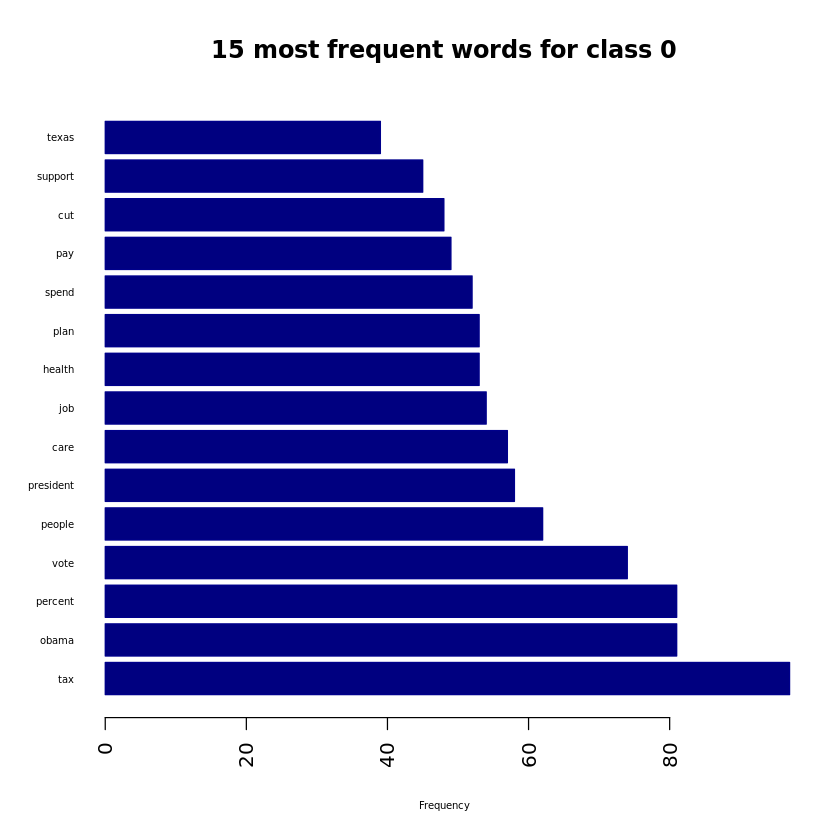

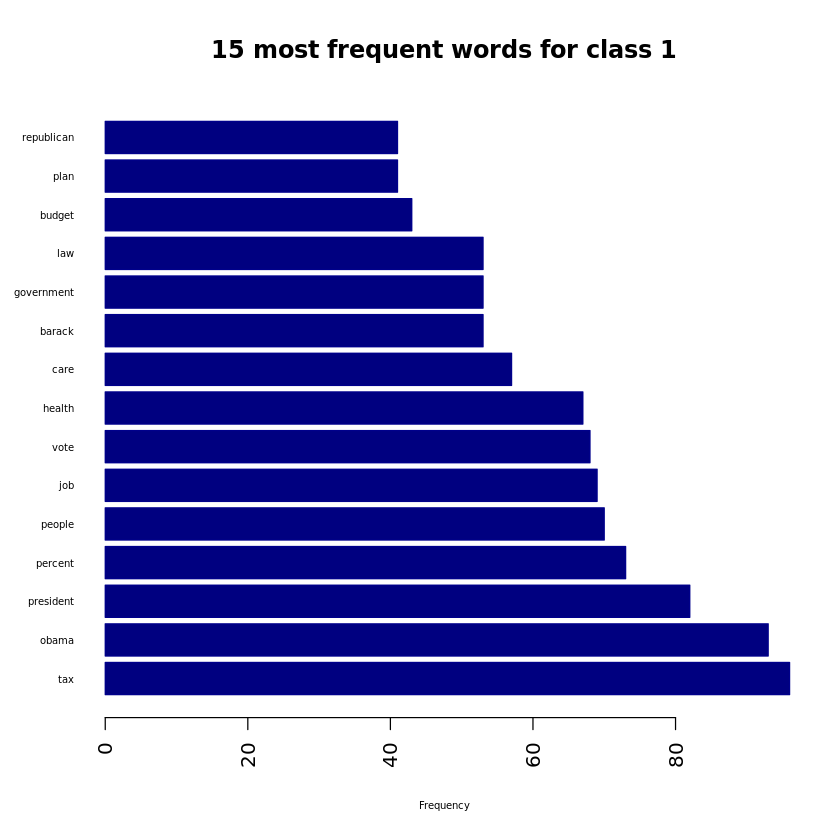

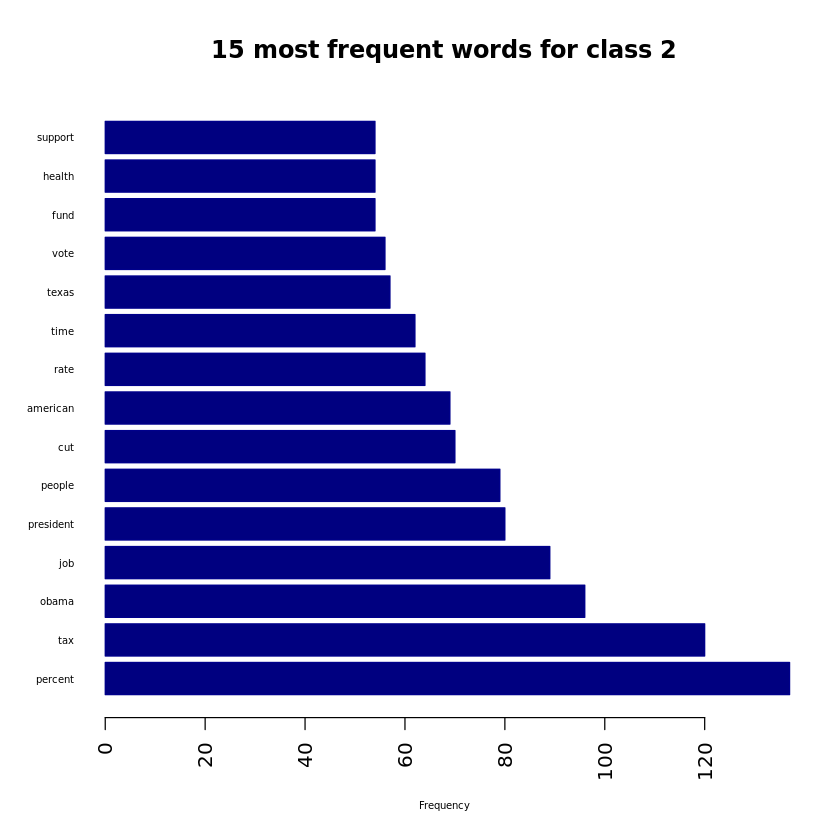

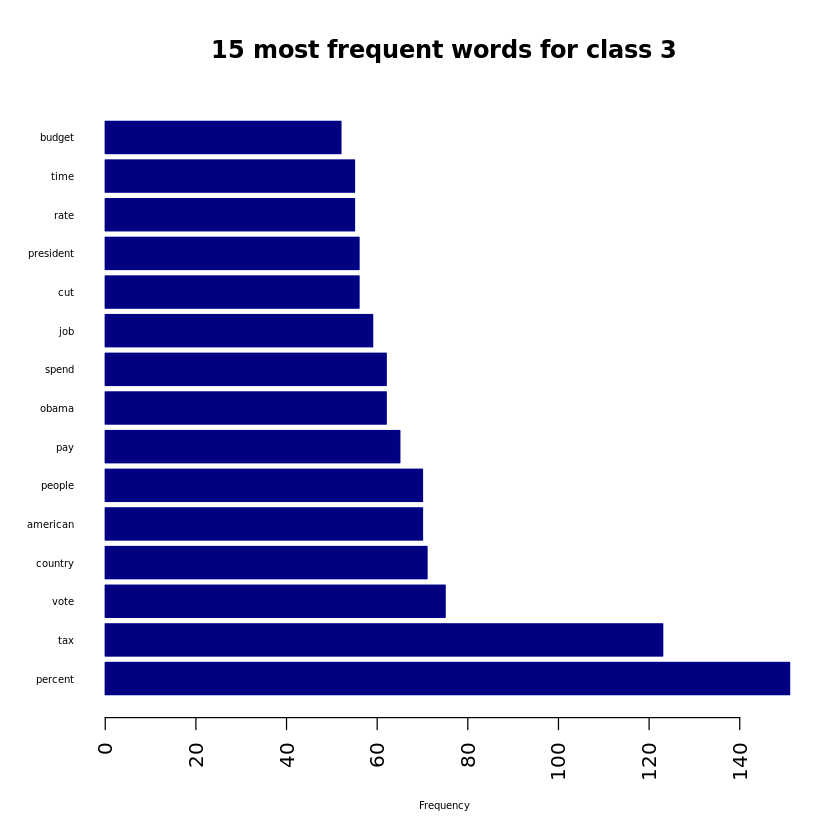

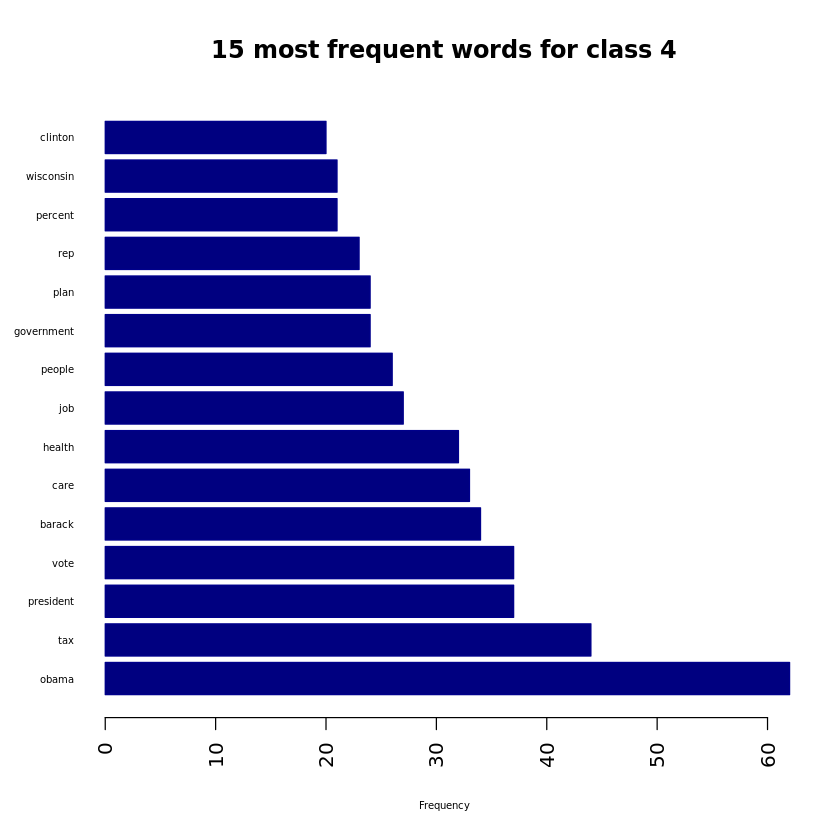

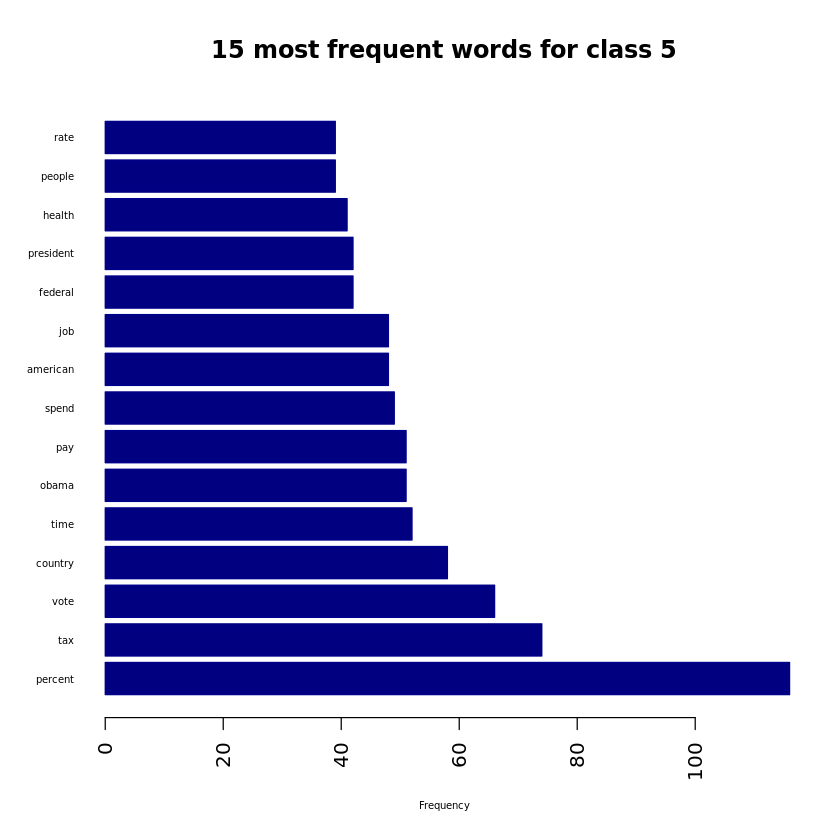

In [ ]:
#the algorithm to train 
library("dplyr")
#par(mfrow=c(6,1))
for (c in C) {
  dfi <- filter(df.train, Labels == c)  #dataframe contenente tutti e soli i documenti appartenenti alla stessa label
  Ni <- nrow(dfi)        #numero totale di questi documenti
  prior_i <- Ni/N              #prior uniforme per l'i-esima label
  
  textc <- c()                      # raggrupo in un'unica lista tutti i documenti insieme 
  for (j in 1:Ni){
    textc <- c(textc,  dfi$Text[[j]])
  } 
  
  T.cts = as.data.frame(table(factor(textc)))  #frequency table for tokens in textc----> missing all tokens in general vocabulary
  
  # visualization of most frequent words for each class
  T.order = T.cts[order(T.cts$Freq, decreasing=TRUE),] # the dataframe is ordered by frequency
  barplot(T.order[1:15,]$Freq[1:15], 
        names = T.order[1:15,]$Var1[1:15], 
        xlab = "Frequency", 
        ylab = " ", 
        main = paste0("15 most frequent words for class ",c),
        space = NULL,
        col = "navyblue",
        border = "dark blue",
        las = 2,
        cex.lab = 0.5,
        horiz=T,
        cex.names = 0.5)
  
  #searching for tokens in general vocabulary which are not present in vocabulary.i
  vocabulary.i <- textc[!duplicated(textc)]
  diff.voc <- setdiff(vocabulary, vocabulary.i)
  
  #add to the frequency table missing tokens with frequencies equal to 0 
  diff.df <- data.frame(Var1 = diff.voc, Freq = rep(0, length(diff.voc)))
  T.cts.complete <- rbind(T.cts, diff.df)
  
  #calculating the conditional probability for each token 
  
  cond.prob <- (T.cts.complete$Freq + 1)/ (sum(T.cts.complete$Freq) + length(vocabulary))
  T.cts.complete$cond.prob <- cond.prob
  T.cts.complete$prior <- prior_i
    
  write.csv(T.cts.complete, paste(c,"results.csv", sep=""), row.names = FALSE)
}

Osservando i barplot delle frequenze si può già affermare che difficilmente l'algoritmo riuscirà a predire dei buoni risultati

In [ ]:
#PREPARING FOR PREDICTION ON TEST SET

#funzione per scorrere sulle parole di un documento
parole <- function(parola,result.c){
  
  cont <- result.c[result.c$Var1 == parola, ]$cond.prob 
  if(length(cont)> 0) {return(log(cont))}
}
#funzione per fare l'analisi sui vari dataframe delle 6 categorie
read.func <-function(result.c, index){   #results.c è il dataframe che passo
  
  score.c <- log(result.c$prior[1])
  score.c <- score.c + sum(unlist(lapply(df.test$Text[[index]], parole,result.c)))  #parole è una funzione che mi restituisce la somma delle log(cond.prob)
}
#funzione per scorrere su tutti i documenti del test set 
read.doc <- function(doc.index, dataframes){
  
  tot.score <- c()
  tot.score <- unlist(lapply(dataframes[],read.func,doc.index))   #vettore con gli score per ogni categoria
  prediction <- which.max(tot.score)-1  #l'indice che corrisponde allo score massimo -1 
}

In [ ]:
#PREDIZIONE VERA E PROPRIA DEL TEST SET 
mydata <- lapply( paste0(0:5,'results.csv'), read.csv ) #reading dataframes with statistics
predictions <- sapply(1:nrow(df.test), read.doc, mydata)

In [ ]:
#STRUTTURA DDEI RISULTATI
print(str(mydata))
print("***************")
print(str(predictions))

List of 6
 $ :'data.frame':	6422 obs. of  4 variables:
  ..$ Var1     : chr [1:6422] "9" "aarp" "abbott" "abc" ...
  ..$ Freq     : int [1:6422] 1 1 2 1 1 3 1 14 1 2 ...
  ..$ cond.prob: num [1:6422] 0.000143 0.000143 0.000214 0.000143 0.000143 ...
  ..$ prior    : num [1:6422] 0.158 0.158 0.158 0.158 0.158 ...
 $ :'data.frame':	6422 obs. of  4 variables:
  ..$ Var1     : chr [1:6422] "10" "4" "6" "7" ...
  ..$ Freq     : int [1:6422] 1 3 1 1 1 1 1 1 2 1 ...
  ..$ cond.prob: num [1:6422] 0.000134 0.000267 0.000134 0.000134 0.000134 ...
  ..$ prior    : num [1:6422] 0.196 0.196 0.196 0.196 0.196 ...
 $ :'data.frame':	6422 obs. of  4 variables:
  ..$ Var1     : chr [1:6422] "4" "aarp" "aba" "abbott" ...
  ..$ Freq     : int [1:6422] 3 1 1 4 2 1 2 1 18 2 ...
  ..$ cond.prob: num [1:6422] 0.000246 0.000123 0.000123 0.000308 0.000185 ...
  ..$ prior    : num [1:6422] 0.203 0.203 0.203 0.203 0.203 ...
 $ :'data.frame':	6422 obs. of  4 variables:
  ..$ Var1     : chr [1:6422] "10" "4" "6" "8"

$\Large{\textbf{Valutazione dei risultati}}$

In [ ]:
#valutazione dei risultati
comparison <- data.frame(Predictions = as.integer(predictions) , Labels = df.test$Labels) 
good.ones <- comparison[comparison$Predictions == comparison$Labels,] 
cat("correct predictions percentage:",round((length(good.ones$Labels)/length(comparison$Labels))*100,2),"%")


correct predictions percentage: 23.77 %

Per valutare come l'algoritmo agisce nel predire i risultati per ogni classe $c$ si è creata una funzione che per ognuna di esse calcola:
* la percentuale di $\textit{true positives}$ $\textbf{tp}$, che corrisponde alla percentuale di documenti appartenenti alla classe $c$ che vengono effettivamente predetti come appartenenti alla classe $c$;
* la percentuale di $\textit{true negatives}$ $\textbf{tn}$, che corrisponde alla percentuale di documenti appartenenti a tutte le classi tranne $c$ (quindi appartenenti a $\bar{c}$) che vengono effettivamente predetti come $\bar{c}$;
* la percentuale di $\textit{false positive}$ $\textbf{fp}$, che corrisponde alla percentuale di documenti appartenenti a $\bar{c}$ ma che viene predetta erroneamente come appartenente alla classe $c$;
* la percentuale di $\textit{false negative}$ $\textbf{fn}$, che corrisponde alla percentuale di documenti che appartiene a $c$ ma che viene erroneamente classificata dall'algoritmo come appartenente a $\bar{c}$

Le quantità appena descritte vengono utilizzate anche per valutare l'accuratezza e la precisione delle predizioni dell'algoritmo per ciascuna delle classi in esame. In particolare:
* $\textit{Accuracy}= \frac{tp+tn}{tp+tn+fp+fn}$, che rappresenta quanto bene il modello riesce a predire correttamente o escludere correttamente una determinata classe;
* $\textit{Precision}= \frac{tp}{tp+fp}$, che rappresenta la percentuale di predizioni corrette sul totale delle predizioni con il label della classe in esame.

In [ ]:
#Controlliamo quale classi hanno i migliori/peggiori risultati
labels <- c("Barely-True", "False", "Half-True", "Mostly-True", "Not-Known", "True")
compare <- function(label){
    c <- labels[[label+1]]
    dataf <- comparison[comparison$Labels == label,] # dataset dei documenti appartenenti al label
    datan <- comparison[comparison$Labels != label,] # dataset dei documenti non appartenenti al label
    good <- dataf[dataf$Predictions == dataf$Labels,] # predizione corretta (tp)
    bad <- dataf[dataf$Predictions != dataf$Labels,] # errore di tipo II (fn)
    false.true <- datan[datan$Predictions == label,] # errore di tipo I (fp)
    neg <- datan[datan$Predictions != label,] # esclusione corretta (tn)
    cat("\nFor class",c,":")
    tp <- length(good$Labels)/length(dataf$Labels)
    cat("\ntrue positive:",round(tp*100,2),"%")
    tn <- length(neg$Labels)/length(datan$Labels)
    cat("\ntrue negative:",round(tn*100,2),"%")
    fp <- length(false.true$Labels)/length(datan$Labels)
    cat("\nfalse positive:",round(fp*100,2),"%")
    fn <- length(bad$Labels)/length(dataf$Labels)
    cat("\nfalse negative:",round(fn*100,2),"%")
    cat("\n\nEvauation for the class:")
    cat("\nAccuracy:",round((tp+tn)/(tp+tn+fp+fn)*100,2),"%")
    cat("\nPrecision:",round(tp/(tp+fp)*100,2),"%")
    cat("\n------------------------------------------------------------------------\n")
    return(c(tp,tn,fp,fn))
}  

In [ ]:
results <- lapply(0:5, compare)


For class Barely-True :
true positive: 15.17 %
true negative: 89.54 %
false positive: 10.46 %
false negative: 84.83 %

Evauation for the class:
Accuracy: 52.36 %
Precision: 59.19 %
------------------------------------------------------------------------

For class False :
true positive: 23.82 %
true negative: 80.83 %
false positive: 19.17 %
false negative: 76.18 %

Evauation for the class:
Accuracy: 52.33 %
Precision: 55.42 %
------------------------------------------------------------------------

For class Half-True :
true positive: 37.33 %
true negative: 71.72 %
false positive: 28.28 %
false negative: 62.67 %

Evauation for the class:
Accuracy: 54.52 %
Precision: 56.9 %
------------------------------------------------------------------------

For class Mostly-True :
true positive: 29.93 %
true negative: 75.18 %
false positive: 24.82 %
false negative: 70.07 %

Evauation for the class:
Accuracy: 52.56 %
Precision: 54.67 %
--------------------------------------------------------------

$\Large{\textbf{Test di affidabilità dell'algoritmo}}$

Le informazioni sul tasso di $\textit{true positives}$ e $\textit{true negatives}$ possono essere utilizzate anche per valutare l'affidabilità delle predizioni dell'algoritmo. La domanda che ci si pone in questo caso è: qual è la probabilità di un documento $d$ di appartenere alla classe $c$ se l'algoritmo lo classifica in questa classe?

Definendo per ogni classe:
* $C$: documento che appartiene a una certa classe $C$
* $T$: documento che viene predetto dall'algoritmo come appartenente alla classe $C$
* $\textit{Sensibilità}= P(T|C)=$ tasso di $\textit{true positives}$
* $\textit{Specificità}= P(\bar{T}|\bar{C})=$ tasso di $\textit{true negatives}$

e avendo precedentemente calcolato i valori delle priors $P(C)$ per ogni classe, si può calcolare la probabilità richiesta $P(C|T)$ sfruttando il teorema di Bayes:
$$
P(C|T)=\frac{P(CT)}{P(T)}=\frac{P(T|C)*P(C)}{P(CT)+P(\bar{C}T)}
$$
dove $P(\bar{C}T)=P(\bar{C})-P(\bar{C}\bar{T})$ e $P(\bar{C}\bar{T})=P(\bar{T}|\bar{C})*P(\bar{C})=P(\bar{T}|\bar{C})*(1-P(C))$

In [ ]:
reliability <- function(index, files){
    collection <- results[[index+1]] # recupero dei rate di true positive e true negative per la classe
    name <- labels[index+1] # recupero del nome della classe corrispondente all'indice
    sens <- collection[1] #sensitivity
    spec <- collection[2] #specificity
    mydata <- read.csv(paste0(index, files), header=TRUE)
    prior <- mydata$prior[[1]]  # recupero della prior della classe
    prior.neg <- 1 - prior # calcolo di p(\bar{C})
    p1 <- sens * prior #prob che sia contemporaneamente vero e ben predetto
    p2 <- spec * prior.neg #prob che sia contemporaneamente falso e non predetto
    #p3 <- prior - p1 #prob che sia contemporaneamente vero e mal predetto
    p4 <- prior.neg - p2 #prob che sia contemporaneamente falso ma predetto
    p.test <- p1 + p4 # calcolo di p(T)
    #p.test.neg <- p2 + p3
    posterior <- p1/p.test # probabilità cercata
    cat(paste0("The percentage probability that the news is ",name),"if the algotithm choose class",index,"is:", round(posterior*100,2),"%\n")
}

In [ ]:
say <- sapply(0:5, reliability, files = 'results.csv')

The percentage probability that the news is Barely-True if the algotithm choose class 0 is: 21.44 %
The percentage probability that the news is False if the algotithm choose class 1 is: 23.31 %
The percentage probability that the news is Half-True if the algotithm choose class 2 is: 25.16 %
The percentage probability that the news is Mostly-True if the algotithm choose class 3 is: 22.58 %
The percentage probability that the news is Not-Known if the algotithm choose class 4 is: 33.48 %
The percentage probability that the news is True if the algotithm choose class 5 is: 24.35 %


Si può concludere che per il primo dataset, dunque per la classificazione delle notizie in cinque classi diverse ma molto simili fra loro, l'algoritmo non riesce a fornire delle predizioni affidabili.

$\Large{\textbf{Naive Bayes per la classificazione binaria}}$

L'algoritmo viene ora testato sul secondo dataset, il quale al contrario di quello precedente presenta solo due classi: falso (0) o vero (1).

In [ ]:
df <- data_preprocessing(df_2)

In [ ]:
df.train <- df[1:(length(df$Labels)*0.6), ]
df.test <- df[ (length(df$Labels)*0.6) : length(df$Labels) , ]
N <- length(df.train$Text)  #tot number of texts
C <- sort(df.train$Labels[!duplicated(df$Labels)]) #single labels
full_text <- c()   #raggrupo in un'unica lista tutti i testi insieme 
  for (j in 1:N){
    full_text <- c(full_text,  df.train$Text[[j]])    #concatenazione di tutte le stringhe, ovvero tutti i testi 
  }
 #print(str(vocabulary))
 
vocabulary <- full_text[!duplicated(full_text)] 

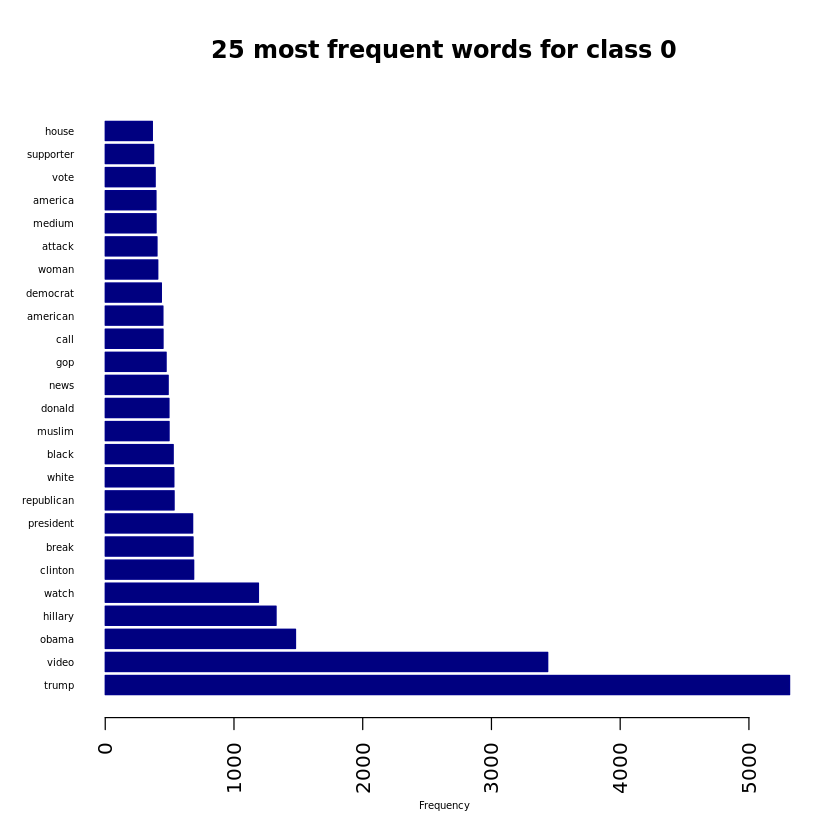

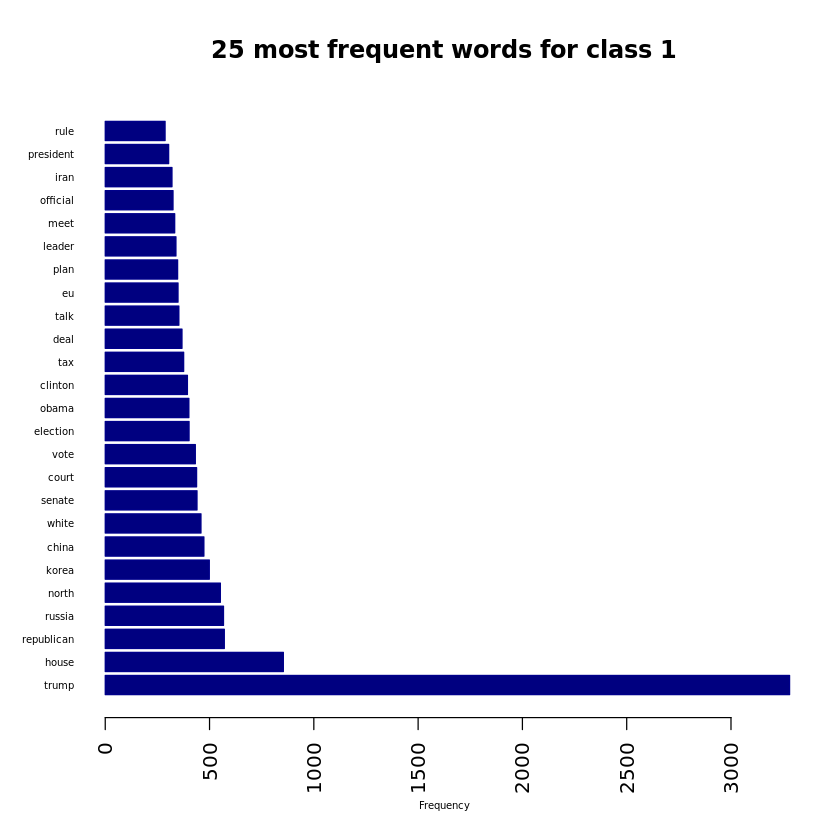

In [ ]:
#the algorithm to train 
library("dplyr")
#par(mfrow=c(2,1))
for (c in C) {
  dfi <- filter(df.train, Labels == c)  #dataframe contenente tutti e soli i testi appartenenti alla stessa label
  Ni <- length(dfi$Text)         #numero totale di questi testi
  prior_i <- Ni/N              #prior uniforme per l'i-esima label
  
  textc <- c()                      #EVENTUALMENTE DA OTTIMIZZARE: raggrupo in un'unica lista tutti i testi insieme 
  for (j in 1:length(dfi$Text)){
    textc <- c(textc,  dfi$Text[[j]])
  } 
  
  T.cts = as.data.frame(table(factor(textc)))      #frequency table for tokens in textc----> missing all tokens in general vocabulary
  T.order = T.cts[order(T.cts$Freq, decreasing=TRUE),]
  barplot(T.order[1:25,]$Freq[1:25], 
        names = T.order[1:25,]$Var1[1:25], 
        xlab = "Frequency", 
        ylab = " ", 
        main = paste0("25 most frequent words for class ",c),
        space = NULL,
        col = "navyblue",
        border = "dark blue",
        las = 2,
        cex.lab = 0.5,
        horiz=T,
        cex.names = 0.5)
  
  #searching for tokens in general vocabulary which are not present in vocabulary.i
  vocabulary.i <- textc[!duplicated(textc)]
  diff.voc <- setdiff(vocabulary, vocabulary.i)
  
  #add to the frequency table missing tokens with frequencies equal to 0 
  diff.df <- data.frame(Var1 = diff.voc, Freq = rep(0, length(diff.voc)))
  T.cts.complete <- rbind(T.cts, diff.df)
  #str(T.cts.complete)
  
  #calculating the conditional probability for each token 

  cond.prob <- (T.cts.complete$Freq + 1)/ (sum(T.cts.complete$Freq) + length(vocabulary))
  T.cts.complete$cond.prob <- cond.prob
  T.cts.complete$prior <- prior_i
    
  write.csv(T.cts.complete, paste(c,"results_bin.csv", sep=""), row.names = FALSE)
  #print(T.cts.complete)
}

In [ ]:
#PREPARING FOR PREDICTION ON TEST SET

#funzione per scorrere sulle parole di un testo
parole <- function(parola,result.c){
  
  cont <- result.c[result.c$Var1 == parola, ]$cond.prob 
  if(length(cont)> 0) {return(log(cont))}
}
#funzione per fare l'analisi sui vari dataframe delle 6 categorie
read.func <-function(result.c, index){   #results.c è il dataframe che passo
  
  score.c <- log(result.c$prior[1])
  score.c <- score.c + sum(unlist(lapply(df.test$Text[[index]], parole,result.c)))  #parole è una funzione che mi restituisce la somma delle log(cond.prob)
}
#funzione per scorrere su tutti i documenti del test set 
read.doc <- function(doc.index, dataframes){
  
  tot.score <- c()
  tot.score <- unlist(lapply(dataframes[],read.func,doc.index))
  prediction <- which.max(tot.score)-1
}

In [ ]:
#PREDIZIONE VERA E PROPRIA DEL TEST SET 
mydata <- lapply( paste0(0:1,'results_bin.csv'), read.csv ) #reading dataframes with statistics
predictions <- sapply(1:length(df.test$Text), read.doc, mydata)

In [ ]:
#valutazione dei risultati
comparison <- data.frame(Predictions = as.integer(predictions) , Labels = df.test$Labels) 
good.ones <- comparison[comparison$Predictions == comparison$Labels,] 
cat("correct predictions percentage:",(length(good.ones$Labels)/length(comparison$Labels))*100,"%")

correct predictions percentage: 92.51072 %

In [ ]:
labels <- c("False","True")
results <- lapply(0:1, compare)


For class False :
true positive: 93.59 %
true negative: 91.34 %
false positive: 8.66 %
false negative: 6.41 %

Evauation for the class:
Accuracy: 92.46 %
Precision: 91.53 %
------------------------------------------------------------------------

For class True :
true positive: 91.34 %
true negative: 93.59 %
false positive: 6.41 %
false negative: 8.66 %

Evauation for the class:
Accuracy: 92.46 %
Precision: 93.44 %
------------------------------------------------------------------------


In [ ]:
say <- sapply(0:1, reliability, files = 'results_bin.csv')

The percentage probability that the news is False if the algotithm choose class 0 is: 92.25 %
The percentage probability that the news is True if the algotithm choose class 1 is: 92.82 %


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=f6ff45f0-c667-4322-bf15-fc6eb0a5ba42' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>